In [2]:
''''In tis main file we do an initial explortation, we clean the data, and perfoirm EDA and vizualisation'''

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import initial_exploration as explo
import data_cleaning as cl

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

In [3]:
# Load datasets:
cash_requests = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

In [4]:
cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [5]:
# Inital exploration:
explo.check(cash_requests)

Number of columns: 16 amd rows: 23970

Data types:
id                              int64
amount                        float64
status                         object
created_at                     object
updated_at                     object
user_id                       float64
moderated_at                   object
deleted_account_id            float64
reimbursement_date             object
cash_request_received_date     object
money_back_date                object
transfer_type                  object
send_at                        object
recovery_status                object
reco_creation                  object
reco_last_update               object
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                    23970
updated_at                    23970
user_id                       10798
moderated_at                  16035
deleted_account_id             1141
reimbursement_dat

In [6]:
cl.convert_dates(cash_requests, cl.cash_request_date_columns)

# Re-check and ensure correct data types in cash_requests:
cl.ensure_correct_data_types(cash_requests, cl.cash_request_date_columns)

cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
1,70,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
2,7,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
3,10,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
4,1594,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT


In [7]:
explo.check(cash_requests)

Number of columns: 16 amd rows: 23970

Data types:
id                                     int64
amount                               float64
status                              category
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
user_id                              float64
moderated_at                  datetime64[ns]
deleted_account_id                   float64
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
transfer_type                       category
send_at                       datetime64[ns]
recovery_status                     category
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                      330
updated_at                      401
user_id      

In [8]:
fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [9]:
explo.check(fees)

Number of columns: 13 amd rows: 21061

Data types:
id                   int64
cash_request_id    float64
type                object
status              object
category            object
total_amount       float64
reason              object
created_at          object
updated_at          object
paid_at             object
from_date           object
to_date             object
charge_moment       object
dtype: object

Unique values count:
id                 21061
cash_request_id    12933
type                   3
status                 4
category               2
total_amount           2
reason             15149
created_at         21026
updated_at         21061
paid_at            15529
from_date           1084
to_date             1560
charge_moment          2
dtype: int64

This columns apear to be categroical:
 Index(['type', 'status', 'category', 'total_amount', 'charge_moment'], dtype='object')

Unique value count for categorical columns:
type
instant_payment    11099
postpone            77

In [10]:
cl.convert_dates(fees, cl.fees_data_date_columns)

# Re-check and ensure correct data types in cfees:
cl.ensure_correct_data_types(fees, cl.fees_data_date_columns)

fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07,2020-10-13,2020-12-17,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09,2020-10-13,2020-12-08,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23,2020-10-23,2020-11-04,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31,2020-10-31,2020-11-19,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06,2020-10-13,2020-11-02,NaT,NaT,after


In [11]:
cl.rename_col(cash_requests, 'id', 'cash_request_id')
data_df = cl.merge_df(cash_requests, fees, 'outer', 'cash_request_id')
data_df = cl.rename_col_xy(data_df)
data_df.head(20)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id,type,fee_status,category,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
0,5.0,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
1,70.0,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2,7.0,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
3,10.0,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
4,1594.0,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5,2145.0,100.0,money_back,2020-05-23,2020-07-06,9489.0,2020-05-24,NaN,2020-06-06,2020-05-26,2020-07-06,regular,NaT,completed,2020-06-12,2020-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6,3512.0,100.0,rejected,2020-06-16,2020-06-17,14631.0,2020-06-17,NaN,2020-07-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
7,654.0,100.0,rejected,2020-02-10,2020-02-10,NaN,2020-02-10,309.0,2020-03-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
8,5672.0,100.0,canceled,2020-06-28,2020-06-28,NaN,NaT,2499.0,2020-07-07,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
9,71.0,90.0,rejected,2019-12-10,2019-12-12,897.0,2019-12-12,NaN,2019-12-17,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN


In [12]:
data_df.sample(10)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id,type,fee_status,category,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
1063,1788.0,100.0,money_back,2020-05-14,2020-06-10,161.0,2020-05-15,NaN,2020-06-05,2020-05-15,2020-06-10,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
11921,24060.0,25.0,direct_debit_rejected,2020-10-24,2020-12-09,50259.0,NaT,NaN,2020-12-01,2020-10-25,2020-12-02,instant,2020-10-24,pending,2020-12-09,2020-12-09,17038.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 24060,2020-10-24,2020-10-24,2020-12-04,NaT,NaT,after
14073,2626.0,100.0,money_back,2020-06-05,2020-12-18,12454.0,2020-06-06,NaN,2020-08-08,2020-06-09,2020-08-12,regular,NaT,completed,2020-08-12,2020-08-12,631.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 2626,2020-06-25,2020-10-13,NaT,2020-07-09,2020-08-08,after
20494,14983.0,100.0,money_back,2020-09-07,2020-12-18,9002.0,2020-09-07,NaN,2020-10-02,2020-09-09,2020-10-02,instant,2020-09-14,NaN,NaT,NaT,6595.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 14983,2020-09-07,2020-10-13,2020-10-02,NaT,NaT,after
2806,5442.0,100.0,rejected,2020-06-26,2020-06-26,10298.0,2020-06-26,NaN,2020-07-06,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5669,12586.0,100.0,rejected,2020-08-15,2020-08-15,34125.0,2020-08-15,NaN,2020-08-29,NaT,NaT,instant,2020-08-22,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
24805,20396.0,100.0,money_back,2020-10-10,2020-12-18,21724.0,NaT,NaN,2020-11-06,NaT,2020-11-06,instant,2020-10-10,NaN,NaT,NaT,20691.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 20396,2020-10-31,2020-10-31,NaT,2020-11-06,2020-11-10,before
12826,5942.0,100.0,money_back,2020-06-30,2020-12-18,18223.0,2020-06-30,NaN,2020-08-04,2020-07-02,2020-08-04,regular,NaT,NaN,NaT,NaT,2386.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 5942,2020-07-30,2020-10-13,NaT,2020-08-04,2020-08-17,after
18915,13454.0,70.0,money_back,2020-08-21,2020-12-18,35671.0,2020-08-21,NaN,2020-09-25,2020-08-21,2020-09-29,instant,2020-08-28,NaN,NaT,NaT,4541.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 13454,2020-08-21,2020-10-13,2020-09-29,NaT,NaT,after
13910,2685.0,50.0,money_back,2020-06-07,2020-12-18,NaN,2020-06-07,4478.0,2020-07-05,2020-06-09,2020-08-05,regular,NaT,completed,2020-07-17,2020-08-05,180.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 2685,2020-06-23,2020-10-13,NaT,2020-07-05,2020-08-04,after


In [13]:
cl.rename_col(data_df, 'id', 'id_fee')
cl.clean_text_column(data_df, "reason")
explo.check(data_df)

Number of columns: 28 amd rows: 32098

Data types:
cash_request_id                      float64
amount                               float64
CR_status                           category
CR_created_at                 datetime64[ns]
CR_updated_at                 datetime64[ns]
user_id                              float64
moderated_at                  datetime64[ns]
deleted_account_id                   float64
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
transfer_type                       category
send_at                       datetime64[ns]
recovery_status                     category
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
id_fee                               float64
type                                category
fee_status                          category
category                            category
total_amount                         float64
reas

In [14]:
data_df = cl.remove_nan(data_df, "cash_request_id")
explo.check_null(data_df)

4 rows were removed

Count of null values:
cash_request_id                   0
amount                            0
CR_status                         0
CR_created_at                     0
CR_updated_at                     0
user_id                        2572
moderated_at                  10335
deleted_account_id            29521
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
transfer_type                     0
send_at                        9724
recovery_status               24894
reco_creation                 24894
reco_last_update              24894
id_fee                        11037
type                          11037
fee_status                    11037
category                      29898
total_amount                  11037
reason                        11037
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date              

In [15]:
data_df = cl.drop_col(data_df, ["id_fee", "category"])
data_df.head(10)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,type,fee_status,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
0,5.0,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
1,70.0,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2,7.0,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
3,10.0,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
4,1594.0,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5,2145.0,100.0,money_back,2020-05-23,2020-07-06,9489.0,2020-05-24,NaN,2020-06-06,2020-05-26,2020-07-06,regular,NaT,completed,2020-06-12,2020-07-06,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6,3512.0,100.0,rejected,2020-06-16,2020-06-17,14631.0,2020-06-17,NaN,2020-07-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
7,654.0,100.0,rejected,2020-02-10,2020-02-10,NaN,2020-02-10,309.0,2020-03-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
8,5672.0,100.0,canceled,2020-06-28,2020-06-28,NaN,NaT,2499.0,2020-07-07,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
9,71.0,90.0,rejected,2019-12-10,2019-12-12,897.0,2019-12-12,NaN,2019-12-17,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN


In [16]:
explo.check_null(data_df)

Count of null values:
cash_request_id                   0
amount                            0
CR_status                         0
CR_created_at                     0
CR_updated_at                     0
user_id                        2572
moderated_at                  10335
deleted_account_id            29521
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
transfer_type                     0
send_at                        9724
recovery_status               24894
reco_creation                 24894
reco_last_update              24894
type                          11037
fee_status                    11037
total_amount                  11037
reason                        11037
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date                       24328
charge_moment                 11037
dtype: int64


In [17]:
frames = cl.selecting_data_types(data_df)
num = frames[1]
cat = frames[0]
date = frames[2]

In [18]:
num.head()

,amount,user_id
0,100.0,804.0
1,100.0,231.0
2,100.0,191.0
3,99.0,761.0
4,100.0,7686.0


In [19]:
explo.check_null(num)

Count of null values:
amount        0
user_id    2572
dtype: int64


In [20]:
cat.head()

,CR_status,transfer_type,recovery_status,type,fee_status,reason,charge_moment,total_amount
0,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
1,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
2,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
3,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
4,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
explo.check_null(cat)

Count of null values:
CR_status              0
transfer_type          0
recovery_status    24894
type               11037
fee_status         11037
reason             11037
charge_moment      11037
total_amount       11037
dtype: int64


In [22]:
date.head()

,CR_created_at,CR_updated_at,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,send_at,reco_creation,reco_last_update,fee_created_at,fee_updated_at,paid_at,from_date,to_date
0,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-12-10,2019-12-18,2019-12-18,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2020-05-06,2020-05-07,2020-05-07,2020-06-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [23]:
explo.check_null(date)

Count of null values:
CR_created_at                     0
CR_updated_at                     0
moderated_at                  10335
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
send_at                        9724
reco_creation                 24894
reco_last_update              24894
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date                       24328
dtype: int64


In [24]:
# Verify specific date columns' data types in cash_requests:
print("\nCheck data types of date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].dtypes)

# Check for any NaT in date columns:
print("\nCheck NaT (missing values) in date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].isna().sum())


Check data types of date columns:
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
moderated_at                  datetime64[ns]
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
send_at                       datetime64[ns]
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Check NaT (missing values) in date columns:
created_at                        0
updated_at                        0
moderated_at                   7935
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
send_at                        7504
reco_creation                 20640
reco_last_update              20640
dtype: int64


In [25]:
df_time_between_CR_and_money_back = cl.process_date_columns(date, "CR_created_at", "money_back_date")
df_time_between_CR_and_money_back.head()

,CR_created_at,money_back_date,days_difference
5,2020-05-23,2020-07-06,44
11,2020-05-14,2020-06-03,20
13,2020-05-22,2020-06-13,22
43,2020-05-08,2020-06-10,33
48,2020-10-23,2020-11-06,14


In [26]:
explo.check(df_time_between_CR_and_money_back)

Number of columns: 3 amd rows: 23917

Data types:
CR_created_at      datetime64[ns]
money_back_date    datetime64[ns]
days_difference             int64
dtype: object

Unique values count:
CR_created_at      314
money_back_date    315
days_difference    206
dtype: int64

This columns apear to be categroical:
 Index([], dtype='object')

Unique value count for categorical columns:
Count of null values:
CR_created_at      0
money_back_date    0
days_difference    0
dtype: int64

Count of duplicated values:
18132


In [27]:
df_time_between_fee_created_and_paid_at_date = cl.process_date_columns(date, "fee_created_at", "paid_at")
df_time_between_fee_created_and_paid_at_date.head(20)

,fee_created_at,paid_at,days_difference
48,2020-10-23,2020-11-06,14
170,2020-10-17,2020-10-17,0
171,2020-10-15,2020-10-31,16
233,2020-06-28,2020-06-28,0
307,2020-07-05,2020-08-06,32
330,2020-07-07,2020-07-07,0
331,2020-07-08,2020-07-08,0
332,2020-10-04,2020-10-30,26
333,2020-09-04,2020-10-30,56
423,2020-10-09,2020-11-06,28


In [28]:
explo.check(df_time_between_fee_created_and_paid_at_date)

Number of columns: 3 amd rows: 15438

Data types:
fee_created_at     datetime64[ns]
paid_at            datetime64[ns]
days_difference             int64
dtype: object

Unique values count:
fee_created_at     132
paid_at            229
days_difference    165
dtype: int64

This columns apear to be categroical:
 Index([], dtype='object')

Unique value count for categorical columns:
Count of null values:
fee_created_at     0
paid_at            0
days_difference    0
dtype: int64

Count of duplicated values:
11315


In [29]:
# We can divide the columns between us and ecah work in a set of columns performing an 
# univariate analysis (frequency plots, box plots, doughnut, histograms   or any other you concider)
#For numercial plots also create report in mean , meadian, std, and arrive to conclusions 

In [30]:
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')
#create cohort using dates from the first transactions, and grouping all users according to user id.

In [31]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
# extracts month and year from the first advance column and converts it to a period format.

In [32]:
data_df['cohort_index'] = (data_df['CR_created_at'].dt.year - data_df['first_advance_date'].dt.year) * 12 + \
                     (data_df['CR_created_at'].dt.month - data_df['first_advance_date'].dt.month) + 1
# finds difference in years between two dates, *12 converts into months.
print(data_df.info()) #check if the cohort column exists

<class 'pandas.core.frame.DataFrame'>
Index: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_request_id             32094 non-null  float64       
 1   amount                      32094 non-null  float64       
 2   CR_status                   32094 non-null  category      
 3   CR_created_at               32094 non-null  datetime64[ns]
 4   CR_updated_at               32094 non-null  datetime64[ns]
 5   user_id                     29522 non-null  float64       
 6   moderated_at                21759 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          32094 non-null  datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             23917 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  category      


In [33]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
data_df.groupby('cohort_month').size()
# extracts the month and year from the list of first advance and creates a new column, 
# cohort month, that shows when each user fisrt interacted with the service.


cohort_month
2019-11      13
2019-12    1009
2020-01     383
2020-02     510
2020-03     394
2020-04    1062
2020-05    1930
2020-06    6706
2020-07    5214
2020-08    2135
2020-09    3949
2020-10    6142
2020-11      75
Freq: M, dtype: int64

In [34]:
cohort_table = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()
cohort_table = cohort_table.unstack()
cohort_table = cohort_table.fillna(0)
print(cohort_table)

CR_created_at  2019-11  2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  \
cohort_month                                                                   
2019-11            1.0      1.0      0.0      0.0      0.0      1.0      5.0   
2019-12            0.0    229.0     75.0     46.0     66.0     66.0     79.0   
2020-01            0.0      0.0    101.0     21.0     15.0     35.0     32.0   
2020-02            0.0      0.0      0.0     90.0     48.0     48.0     57.0   
2020-03            0.0      0.0      0.0      0.0     78.0     39.0     42.0   
2020-04            0.0      0.0      0.0      0.0      0.0    229.0    154.0   
2020-05            0.0      0.0      0.0      0.0      0.0      0.0    509.0   
2020-06            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-07            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-08            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-09            0.0      0.0      0.0

In [35]:
cohort_size = data_df.groupby('cohort_month')['user_id'].nunique()
# counts how many unique users belong to each cohort month. 
cohort_size


cohort_month
2019-11       1
2019-12     204
2020-01      90
2020-02      84
2020-03      69
2020-04     212
2020-05     369
2020-06    1338
2020-07    1294
2020-08     656
2020-09    1712
2020-10    4694
2020-11      75
Freq: M, Name: user_id, dtype: int64

In [36]:
# count the number of times each user used the service in each month
cohort_usage = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()

# each row is a cohort, and each column is a month
cohort_usage = cohort_usage.unstack(fill_value=0)




In [37]:
# Define relevant incident types based on the 'reason' column:
incident_reasons = ['rejected direct debit', 'month delay on payment']

# Filter data for rows that have incidents:
incident_data = data_df[data_df['reason'].isin(incident_reasons)]

# Group by cohort month and count the number of incidents per cohort:
incident_counts = incident_data.groupby('cohort_month')['user_id'].nunique()

# Group by cohort month to count total requests:
total_requests = data_df.groupby('cohort_month')['user_id'].nunique()

# Calculate incident rate (number of incidents / total requests per cohort):
incident_rate = incident_counts / total_requests * 100

# Print incident rate by cohort:
print(incident_rate)


cohort_month
2019-11          NaN
2019-12    12.745098
2020-01    10.000000
2020-02    15.476190
2020-03    23.188406
2020-04    23.113208
2020-05    28.997290
2020-06    29.970105
2020-07    25.888717
2020-08    18.750000
2020-09    11.098131
2020-10     0.489987
2020-11          NaN
Freq: M, Name: user_id, dtype: float64


In [ ]:
# Frequency table with absolute counts:
frequency_table = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Add total column for each cohort month:
frequency_table['Total Incidents'] = frequency_table.sum(axis=1)

# Display table:
print(frequency_table)


reason        month delay on payment  rejected direct debit  Total Incidents
cohort_month                                                                
2019-12                           12                     30               42
2020-01                           10                     11               21
2020-02                            9                     15               24
2020-03                           10                     19               29
2020-04                           49                     64              113
2020-05                           68                    136              204
2020-06                          218                    479              697
2020-07                          164                    378              542
2020-08                           21                    124              145
2020-09                            0                    190              190
2020-10                            0                     23               23

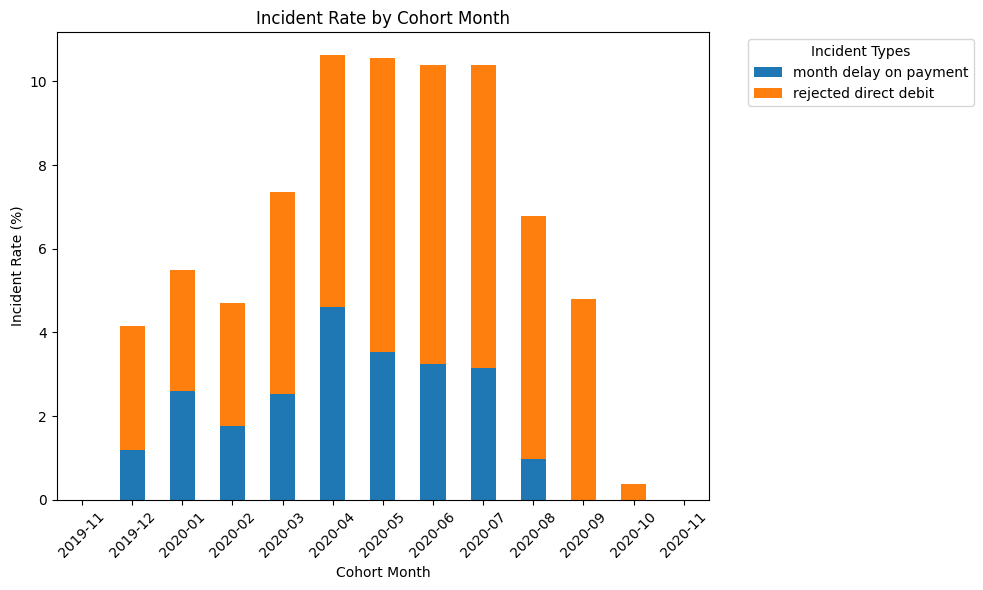

In [38]:
import matplotlib.pyplot as plt

# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Compute total requests per cohort:
total_requests = data_df.groupby('cohort_month').size()

# Calculate incident rate as a percentage:
incident_rate = (incident_counts.div(total_requests, axis=0) * 100)

# Plot stacked bar chart:
incident_rate.plot(kind='bar', stacked=True, figsize=(10, 6))

# Labels and formatting:
plt.title('Incident Rate by Cohort Month')
plt.ylabel('Incident Rate (%)')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


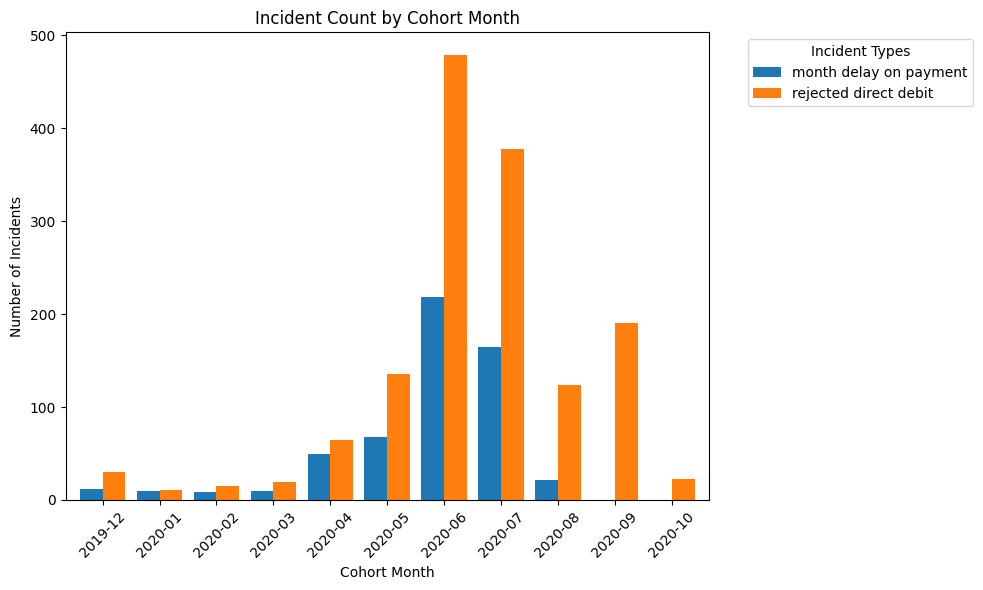

In [ ]:
import matplotlib.pyplot as plt

# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Plot grouped bar chart:
incident_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Labels and formatting:
plt.title('Incident Count by Cohort Month')
plt.ylabel('Number of Incidents')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
